# PROV Python Library - A Short Tutorial

The [PROV Python library](https://pypi.python.org/pypi/prov) is an implementation of the [Provenance Data Model](http://www.w3.org/TR/prov-dm/) by the World Wide Web Consortium. This tutorial shows how to use the library to:

* create provenance statements in Python;
* export the provenance to [PROV-N](http://www.w3.org/TR/prov-n/), [PROV-JSON](https://openprovenance.org/prov-json/), and graphical representations like PNG, SVG, PDF; and
* store and retrieve provenance on [ProvStore](https://openprovenance.org/store/).

## Installation

To install the prov library using [pip](http://pip.pypa.io/) with support for graphical exports:
```bash
pip install prov[dot]
```
Note: We recommend using [virtualenv](http://virtualenv.readthedocs.org/) (and the excellent companion [virtualenvwrapper](http://virtualenvwrapper.readthedocs.org/)) to avoid package version conflicts. 

If you want to open [this notebook](https://raw.githubusercontent.com/trungdong/notebooks/master/PROV%20Tutorial.ipynb) and run it locally, install [Jupyter notebook](https://jupyter.readthedocs.io/en/latest/content-quickstart.html) (in the same virtualenv) and start the notebook server in the folder where this notebook is saved:
```bash
pip install jupyter
jupyter notebook
```

## Create a simple provenance document

In this tutorial, we use the Data Journalism example from [Provenance: An Introduction to PROV](http://www.provbook.org/) by [Luc Moreau](https://nms.kcl.ac.uk/luc.moreau/) and [Paul Groth](http://pgroth.com/). If you do not have access to the book, you can find the example from the [slides](http://www.provbook.org/tutorial/provenanceweek2014/prov-tutorial.pptx) by Luc and Paul (starting from slide #15). Please familarise yourself with the example and relevant PROV concepts (i.e. [entity](http://www.w3.org/TR/prov-primer/#entities), [activity](http://www.w3.org/TR/prov-primer/#activities), [agent](http://www.w3.org/TR/prov-primer/#agents-and-responsibility), ...) before proceeding with this tutorial.

To create a provenance document (a package of provenance statements or assertions), import `ProvDocument` class from `prov.model`:

In [1]:
from prov.model import ProvDocument

In [2]:
# Create a new provenance document
d1 = ProvDocument()  # d1 is now an empty provenance document

Before asserting provenance statements, we need to have a way to refer to the "things" we want to describe provenance (e.g. articles, data sets, people). For that purpose, PROV uses [qualified names](http://www.w3.org/TR/prov-dm/#term-identifier) to identify things, which essentially a shortened representation of a [URI](http://en.wikipedia.org/wiki/Uniform_resource_identifier) in the form of `prefix:localpart`. Valid qualified names require their prefixes defined, which we is going to do next.

In [3]:
# Declaring namespaces for various prefixes used in the example
d1.add_namespace('now', 'http://www.provbook.org/nownews/')
d1.add_namespace('nowpeople', 'http://www.provbook.org/nownews/people/')
d1.add_namespace('bk', 'http://www.provbook.org/ns/#')

<Namespace: bk {http://www.provbook.org/ns/#}>

Now we can create things like entities, agents and relate them with one another in a PROV document.

In [4]:
# Entity: now:employment-article-v1.html
e1 = d1.entity('now:employment-article-v1.html')
# Agent: nowpeople:Bob
d1.agent('nowpeople:Bob')

<ProvAgent: nowpeople:Bob>

The first statement above create an entity referred to as `now:employment-article-v1.html`, which is the first version of the article about employment in our example. Note that although we provided a string as the entity's identifier, since `now` is a registered prefix, the library *automatically* convert the string into a valid qualified name. The newly created entity is assigned to `e1`.

Similarly, the second statement create an agent called `nowpeople:Bob`. Apart from the `d1.` part at the begining of each Python statement, these statements closely resemble the correstponding PROV-N statements to assert the same information. This is a principle we followed when designing the prov library, as can be seen throughout this tutorial.

In [5]:
# Attributing the article to the agent
d1.wasAttributedTo(e1, 'nowpeople:Bob')

<ProvAttribution: (now:employment-article-v1.html, nowpeople:Bob)>

In [6]:
# What we have so far (in PROV-N)
print(d1.get_provn())

document
  prefix now <http://www.provbook.org/nownews/>
  prefix nowpeople <http://www.provbook.org/nownews/people/>
  prefix bk <http://www.provbook.org/ns/#>
  
  entity(now:employment-article-v1.html)
  agent(nowpeople:Bob)
  wasAttributedTo(now:employment-article-v1.html, nowpeople:Bob)
endDocument


We can add more to our simple document. The following adds a new entity `govftp:oesm11st.zip`, which is a `void:Dataset` and has the label `employment-stats-2011`. The entity's type and label are domain-specific information; similar information can be added to any record as the last argument of a statement (or as a keyword argument `other_attributes`).

The last statement below then asserts that the article `now:employment-article-v1.html` was derived from the data set.

In [7]:
# add more namespace declarations
d1.add_namespace('govftp', 'ftp://ftp.bls.gov/pub/special.requests/oes/')
d1.add_namespace('void', 'http://vocab.deri.ie/void#')

# 'now:employment-article-v1.html' was derived from at dataset at govftp
d1.entity('govftp:oesm11st.zip', {'prov:label': 'employment-stats-2011', 'prov:type': 'void:Dataset'})
d1.wasDerivedFrom('now:employment-article-v1.html', 'govftp:oesm11st.zip')

<ProvDerivation: (now:employment-article-v1.html, govftp:oesm11st.zip)>

In [8]:
print(d1.get_provn())

document
  prefix now <http://www.provbook.org/nownews/>
  prefix nowpeople <http://www.provbook.org/nownews/people/>
  prefix bk <http://www.provbook.org/ns/#>
  prefix govftp <ftp://ftp.bls.gov/pub/special.requests/oes/>
  prefix void <http://vocab.deri.ie/void#>
  
  entity(now:employment-article-v1.html)
  agent(nowpeople:Bob)
  wasAttributedTo(now:employment-article-v1.html, nowpeople:Bob)
  entity(govftp:oesm11st.zip, [prov:label="employment-stats-2011", prov:type="void:Dataset"])
  wasDerivedFrom(now:employment-article-v1.html, govftp:oesm11st.zip, -, -, -)
endDocument


Following the example, we further extend the document with an activity, a usage, and a generation statement.

In [9]:
# Adding an activity
d1.add_namespace('is', 'http://www.provbook.org/nownews/is/#')
d1.activity('is:writeArticle')

<ProvActivity: is:writeArticle>

In [10]:
# Usage and Generation
d1.used('is:writeArticle', 'govftp:oesm11st.zip')
d1.wasGeneratedBy('now:employment-article-v1.html', 'is:writeArticle')

<ProvGeneration: (now:employment-article-v1.html, is:writeArticle)>

## Graphics export (PNG and PDF)

In addition to the PROV-N output (as above), the document can be exported into a graphical representation with the help of the [GraphViz](http://www.graphviz.org/). It is provided as a software package in popular Linux distributions, or can be [downloaded](http://www.graphviz.org/download/) for Windows and Mac.

Once you have GraphViz installed and the `dot` command available in your operating system's paths, you can save the document we have so far into a PNG file as follows.

In [11]:
# visualize the graph
from prov.dot import prov_to_dot
dot = prov_to_dot(d1)
dot.write_png('article-prov.png')

The above saves the PNG file as `article-prov.png` in your current folder. If you're runing this tutorial in Jupyter Notebook, you can see it here as well.

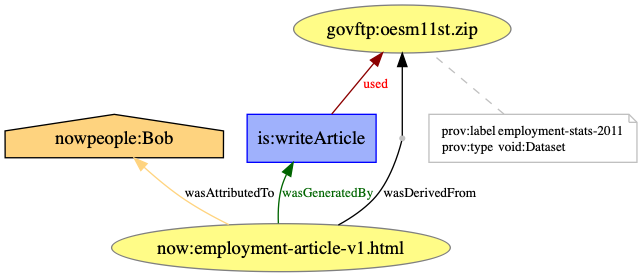

In [12]:
from IPython.display import Image
Image('article-prov.png')

In [13]:
# Or save to a PDF
dot.write_pdf('article-prov.pdf')

Similarly, the above saves the document into a PDF file in your current working folder. Graphviz supports a wide ranges of [raster and vector outputs](http://www.graphviz.org/doc/info/output.html), to which you can export your provenance documents created by the library. To find out what formats are available from your version, run `dot -T?` at the command line.

## PROV-JSON export

[PROV-JSON](https://provenance.ecs.soton.ac.uk/prov-json/) is a JSON representation for PROV that was designed for the ease of accessing various PROV elements in a PROV document and to work well with web applications. The format is natively supported by the library and is its default serialisation format.

In [14]:
print(d1.serialize(indent=2))

{
  "prefix": {
    "now": "http://www.provbook.org/nownews/",
    "nowpeople": "http://www.provbook.org/nownews/people/",
    "bk": "http://www.provbook.org/ns/#",
    "govftp": "ftp://ftp.bls.gov/pub/special.requests/oes/",
    "void": "http://vocab.deri.ie/void#",
    "is": "http://www.provbook.org/nownews/is/#"
  },
  "entity": {
    "now:employment-article-v1.html": {},
    "govftp:oesm11st.zip": {
      "prov:label": "employment-stats-2011",
      "prov:type": "void:Dataset"
    }
  },
  "agent": {
    "nowpeople:Bob": {}
  },
  "wasAttributedTo": {
    "_:id1": {
      "prov:entity": "now:employment-article-v1.html",
      "prov:agent": "nowpeople:Bob"
    }
  },
  "wasDerivedFrom": {
    "_:id2": {
      "prov:generatedEntity": "now:employment-article-v1.html",
      "prov:usedEntity": "govftp:oesm11st.zip"
    }
  },
  "activity": {
    "is:writeArticle": {}
  },
  "used": {
    "_:id3": {
      "prov:activity": "is:writeArticle",
      "prov:entity": "govftp:oesm11st.zip"
   

You can also serialize the document directly to a file by providing a filename (below) or a Python File object.

In [15]:
d1.serialize('article-prov.json')

## XML and RDF Support

The library also supports XML and RDF serialisations for PROV (see [PROV-XML](https://www.w3.org/TR/prov-xml/) and [PROV-O](https://www.w3.org/TR/prov-o/) for more information).

We just need to specify the format that we require during export and import, as shown below.

In [16]:
d1.serialize('article-prov.xml', format='xml')

For RDF export, we also need to specify a specific RDF serialisation. We use the [Turtle format](https://www.w3.org/TR/turtle/) in this case. For the list of supported RDF serialisations, please refer to the [RDFLib documentation](https://rdflib.readthedocs.io/).

In [17]:
d1.serialize('article-prov.ttl', format='rdf', rdf_format='ttl')

## Store and retrieve provenance documents from ProvStore

Having the created a provenance document, you can upload it to [ProvStore](https://openprovenance.org/store/), a free repository for provenance documents, to share it publicly/privately, or simply just to store and retrieve it back at a later time.
In addition to storage and sharing, you can also retrieve your documents on ProvStore in further formats like XML and RDF, transform, and/or visualise them in various ways (see [this poster](http://eprints.soton.ac.uk/365509/) for examples).

Before storing your document there, you need to [register for an account](https://openprovenance.org/store/). You can then upload the PROV-N or PROV-JSON export above via ProvStore's website. However, if you [generated an API Key](https://openprovenance.org/store/account/developer/) for your account, you can also upload the document there directly from this tutorial as shown below.

A wrapper for [ProvStore's REST API](https://openprovenance.org/store/help/api/) is provided by the package [provstore-api](https://github.com/millar/provstore-api#installation). Please follow the [installation instructions](https://github.com/millar/provstore-api#installation) there before proceeding.

In [18]:
# Configure ProvStore API Wrapper with your API Key
from provstore.api import Api
# see your API key at https://openprovenance.org/store/account/developer/
api = Api(base_url='https://openprovenance.org/store/api/v0', username='<your-username>', api_key='<your-API-key>')

In [19]:
# Submit the document to ProvStore
provstore_document = api.document.create(d1, name='article-prov', public=True)

# Generate a nice link to the document on ProvStore so you don't have to find it manually 
from IPython.display import HTML
document_uri = provstore_document.url
HTML('<a href="%s" target="_blank">Open your new provenance document on ProvStore</a>' % document_uri)

The first statement above submit the document `d1` to ProvStore, giving it a name (required) and making it visible to everyone (optional and private by default). Clicking on the link generated will open the page on ProvStore for the document you just submitted.

The returned object is a wrapper for the document on ProvStore identified by `provstore_document.id`, with which you can, of course, retrieve the document again from ProvStore.

In [20]:
# Retrieve it back
retrieved_document = api.document.get(provstore_document.id)
d2 = retrieved_document.prov
d1 == d2  # Is it the same document we submitted?

True

You can also remove the document from ProvStore via its API. It is a good idea to leave your account there nice and tidy anyway.

In [21]:
# Cleaning up, delete the document
retrieved_document.delete()

True

In [22]:
# Just to be sure, trying to retrieve it again
api.document.get(provstore_document.id)  # the document is no longer there

NotFoundException: 

## Further reading

There it is, through a very short tutorial, you have managed to create a provenance document, export it, and store it on the cloud. Simple!

If you want to find out more about how to use the library and ProvStore, here are some references:
* [Prov Python library's documentation](http://prov.readthedocs.io/)
* [ProvStore's API documentation](https://openprovenance.org/store/help/api/)
* Book: [Provenance: An Introduction to PROV](http://www.provbook.org/)
* [Overview of the PROV standards](http://www.w3.org/TR/prov-overview/)

Finally, if you have issues with the Prov Python library, please report them at our [issue tracker on Github](https://github.com/trungdong/prov/issues).

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" href="http://purl.org/dc/dcmitype/InteractiveResource" property="dct:title" rel="dct:type">PROV Python Library - A Short Tutorial</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://about.me/dong.huynh" property="cc:attributionName" rel="cc:attributionURL">Trung Dong Huynh</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.